In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
sys.path.append("..")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
os.environ['LIBRARY_PATH'] = '/usr/local/cuda/lib64'

In [3]:
from pyro import distributions as dist

In [4]:
from model import YModel, OptLoss
from gan import Generator, Discriminator, WSDiscriminator, GANLosses, PsiCompressor
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


from collections import defaultdict
%matplotlib inline

In [5]:
from comet_ml import API
import comet_ml

comet_api = API()
comet_api.get()

['shir994']

In [7]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [8]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(500))

In [190]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

In [18]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

# Check model

In [6]:
exp = comet_api.get("shir994/10d-fit-random/c88ff1f70265498fb97484288a369f49")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [7]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [17]:
psi_compressor = PsiCompressor(10,1)
generator = Generator(NOISE_DIM, out_dim = 1, hidden_dim=128, psi_compressor=psi_compressor,
                      X_dim=1, psi_dim=10).to(device)
# if TASK == 4:
#     discriminator = WSDiscriminator(in_dim=1).to(device)
# else:
#     discriminator = Discriminator(in_dim=1, input_param=3).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
metric_calc = Metrics((-50, 50), 100)

In [9]:
import io

#asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == f"{hyper_params['data_size']}_999.tar"][0]
asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "980.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))

In [10]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [18]:
generator

Generator(
  (fc1): Linear(in_features=31, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (pc): PsiCompressor(
    (fc): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [19]:
generator.load_state_dict(state_dict['gen_state_dict'])

# Test optimisation

In [41]:
from copy import deepcopy

class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
       
    def forward(self, noise, inputs):
        return self.gen(noise, inputs)
    
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    

In [42]:
io_model = InputOptimisation(generator)

# lr = 50
# average_size = 1000



In [63]:
def find_mu(init_mu=0, lr = 50., average_size=1000, n_iter=10000, use_true=False):
    mu_optim = torch.tensor([init_mu] * 10).reshape(1,-1)
    mu_optim = mu_optim.repeat(average_size, 1).to(device)
    mu_optim.requires_grad=True

    losses = []
    m_vals = []
    for _iter in range(n_iter):
        noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
        x = y_sampler.x_dist.sample([average_size, 1]).to(device)
        # Do an update
        if use_true:
            y_sampler.make_condition_sample({"mu": mu_optim, "X":x})
            data_gen = y_sampler.condition_sample()
        else:
            data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
        loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
        losses.append(loss.item())
        io_model.zero_grad()
        loss.backward()
        with torch.no_grad():
            mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
            mu_optim.grad.zero_()
        m_vals.append(mu_optim[0].detach().cpu().numpy())
    m_vals =np.array(m_vals)
    return m_vals, losses

In [ ]:
%%time
m_vals, losses = find_mu(-10., use_true=False,n_iter=50000)

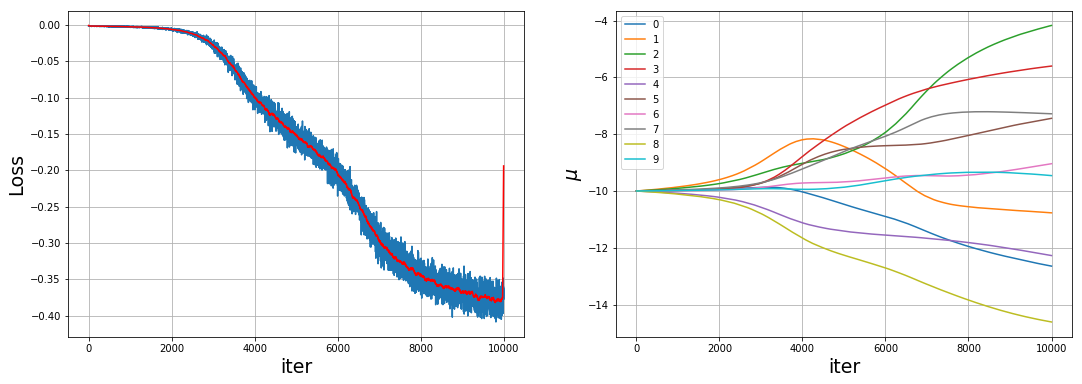

In [69]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

plt.subplot(1,2,2)
for i in range(10):
    plt.plot(m_vals[:,i], label=i);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.legend()

In [70]:
torch.norm(torch.Tensor(m_vals[-1,:]))

tensor(31.1162)

In [75]:
%%time
m_vals, losses = find_mu(-9., use_true=True, n_iter=50000)

CPU times: user 1min 36s, sys: 3.29 s, total: 1min 39s
Wall time: 1min 38s


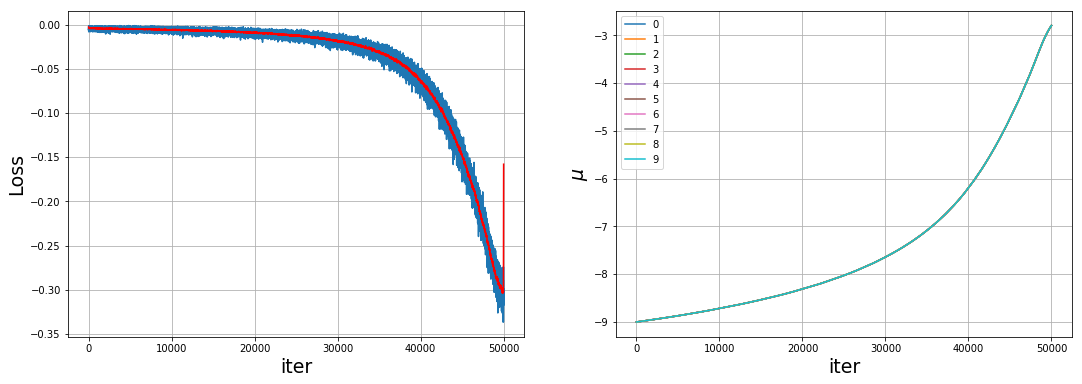

In [76]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

plt.subplot(1,2,2)
for i in range(10):
    plt.plot(m_vals[:,i], label=i);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.legend()

In [77]:
torch.norm(torch.Tensor(m_vals[-1,:]))

tensor(8.8233)